### Overview of Key Configuration Flags

This section summarizes the most important settings in the notebook, which control the execution mode and workflow.

*   **`SMOKE_TEST = False`** (cell_id: `YwTG0SYEswsn`)
    *   `True`: Fast testing mode, where processes run only on a configured mini-dataset. Ideal for quick code validation, but not suitable for generating real results.
    *   `False`: Full execution mode, where the notebook works with the entire dataset. This can take a long time and utilizes GPU resources.

*   **`BASE_MODELS` list** (cell_id: `tI_vS_FQqqD9`)
    *   This list defines the base models you want to use. For each model, you can set:
        *   `"hpo": True/False`: Whether Hyperparameter Optimization (HPO) should run for the given model.
        *   `"train": True/False`: Whether the final training should run for the given model with the best HPO configuration.
    *   **Important:** If you want to run full HPO and training, set these flags to `True` for the desired models. For example:
        ```python
        BASE_MODELS = [
            {"name": "nreimers/MiniLM-L6-H384-uncased", "hpo": True, "hpo_mode": RAW_CONFIG_NAME, "train": True, "train_mode": RAW_CONFIG_NAME},
            # ...
        ]
        ```

*   **`RUN_QUANTIZATION = False`** (cell_id: `tI_vS_FQqqD9`)
    *   `True`: Enables the execution of the quantization and final evaluation of quantized models.
    *   `False`: Skips the quantization phase.
    *   **Note:** Quantization should ideally be run after HPO and final training are complete.

*   **`GENERATE_FINAL_REPORT = False`** (cell_id: `tI_vS_FQqqD9`)
    *   `True`: Enables the generation of the final PDF report.
    *   `False`: Skips report generation.
    *   **Note:** The report will only contain all results if all previous steps (HPO, training, quantization) have been completed.

In [18]:
RAW_CONFIG_NAME = "raw"
SIMPLIFIED_CONFIG_NAME = "simplified"

BASE_MODELS = [
    {"name": "nreimers/MiniLM-L6-H384-uncased", "hpo": True, "hpo_mode": RAW_CONFIG_NAME, "train": False, "train_mode": RAW_CONFIG_NAME, "trained": False},
    {"name": "google/electra-small-discriminator", "hpo": False, "hpo_mode": RAW_CONFIG_NAME, "train": False, "train_mode": RAW_CONFIG_NAME, "trained": False},
    {"name": "roberta-base", "hpo": False, "hpo_mode": RAW_CONFIG_NAME, "train": False, "train_mode": RAW_CONFIG_NAME, "trained": False},
]

RUN_QUANTIZATION = False    # <<< CHANGE TO TRUE when all training has been done after all HPO has been done

GENERATE_FINAL_REPORT = False


In [19]:
# ====================================================
# RUN MODE: SMOKE TEST vs FULL
# ====================================================

SMOKE_TEST = False    # True = tiny debugging subset, False = full HPO
MINI_TRAIN_SIZE = 50
MINI_VALID_SIZE = 20

In [3]:
# ====================================================
# 0. Environment: install, import, Drive mount, config
# ====================================================

# ---- Clean install of HF stack (no Python switching needed) ----
!pip uninstall -y tokenizers transformers datasets evaluate accelerate
!pip cache purge

!pip install -U transformers datasets tokenizers evaluate accelerate

# ---- Standard imports ----
import os
import random
import json
from typing import Dict, Any, List, Tuple

import numpy as np
import torch

# ---- Mount Google Drive ----
from google.colab import drive
drive.mount('/content/drive')

# ---- HuggingFace imports ----
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import load_dataset, DatasetDict, load_from_disk, Dataset
import evaluate
from torch import nn

# ====================================================
# Directory structure
# ====================================================

PROJECT_ROOT = "/content/drive/MyDrive/emotion_project"

if SMOKE_TEST:
    MODE_ROOT = os.path.join(PROJECT_ROOT, "mini")
else:
    MODE_ROOT = os.path.join(PROJECT_ROOT, "full")

DATA_CACHE_DIR = os.path.join(MODE_ROOT, "cache")
TOKENIZED_DIR  = os.path.join(MODE_ROOT, "tokenized")
TRIALS_DIR     = os.path.join(MODE_ROOT, "trials")
FINAL_DIR      = os.path.join(MODE_ROOT, "final_models")
LOGS_DIR       = os.path.join(MODE_ROOT, "logs")

for d in [PROJECT_ROOT, MODE_ROOT, DATA_CACHE_DIR, TOKENIZED_DIR, TRIALS_DIR, FINAL_DIR, LOGS_DIR]:
    os.makedirs(d, exist_ok=True)


# ====================================================
# Model and HPO configs
# ====================================================

MAX_LENGTH = 64
BATCH_SIZE = 8
NUM_EPOCHS = 6
NUM_EPOCHS_HPO = 3
SEED = 42

# ---- Manual HPO grid ----
HPO_GRID = [
    {
        "learning_rate": 2e-5,
        "warmup_ratio": 0.05,
        "weight_decay": 0.01,
        "scheduler": "linear",
        "batch_size": 16,
        "max_length": 64,
        "optimizer": "adamw_torch",
    },
    {
        "learning_rate": 3e-5,
        "warmup_ratio": 0.1,
        "weight_decay": 0.01,
        "scheduler": "cosine",
        "batch_size": 8,
        "max_length": 128,
        "optimizer": "adamw_torch",
    },
    {
        "learning_rate": 5e-5,
        "warmup_ratio": 0.0,
        "weight_decay": 0.0,
        "scheduler": "linear",
        "batch_size": 16,
        "max_length": 64,
        "optimizer": "adafactor",
    },
]

# ---- Reproducibility ----
def set_global_seed(seed: int = SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Found existing installation: tokenizers 0.22.1
Uninstalling tokenizers-0.22.1:
  Successfully uninstalled tokenizers-0.22.1
Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: datasets 4.4.1
Uninstalling datasets-4.4.1:
  Successfully uninstalled datasets-4.4.1
Found existing installation: evaluate 0.4.6
Uninstalling evaluate-0.4.6:
  Successfully uninstalled evaluate-0.4.6
Found existing installation: accelerate 1.11.0
Uninstalling accelerate-1.11.0:
  Successfully uninstalled accelerate-1.11.0
Files removed: 36
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 

In [4]:
from functools import lru_cache
from itertools import chain

GOEMOTIONS_28 = [
    'admiration','amusement','anger','annoyance','approval','caring',
    'confusion','curiosity','desire','disappointment','disapproval','disgust',
    'embarrassment','excitement','fear','gratitude','grief','joy','love',
    'nervousness','optimism','pride','realization','relief','remorse',
    'sadness','surprise'
]

# ====================================================
# RAW label-info (28 labels)
# ====================================================
def get_label_info_raw(ds: DatasetDict) -> Dict[str, Any]:
    train_ds = ds["train"]

    label_names = GOEMOTIONS_28
    num_labels = len(label_names)

    arr = np.stack([train_ds[col] for col in label_names], axis=1).astype(np.float32)
    counts = arr.sum(axis=0)

    N = len(train_ds)

    pos = counts
    neg = N - counts
    pos_weight = neg / (pos + 1e-6)

    id2label = {i: name for i, name in enumerate(label_names)}
    label2id = {name: i for i, name in id2label.items()}

    return {
        "mode": "raw",
        "num_labels": num_labels,
        "id2label": id2label,
        "label2id": label2id,
        "pos_weight": torch.tensor(pos_weight, dtype=torch.float32),
        "class_weights": None,
    }


# ====================================================
# SIMPLIFIED label-info (28 labels)
# ====================================================
def get_label_info_simplified(ds: DatasetDict) -> Dict[str, Any]:
    train_ds = ds["train"]
    features = train_ds.features

    labels_feature = features["labels"]

    # Ensure the feature is a Sequence(ClassLabel)
    if hasattr(labels_feature, "feature") and hasattr(labels_feature.feature, "names"):
        label_names = labels_feature.feature.names
    else:
        raise ValueError("Simplified 'labels' must be Sequence(ClassLabel).")

    num_labels = len(label_names)

    # ---- FAST LABEL COUNTS (for class_weights) ----
    N = len(train_ds) # Total number of samples in the training dataset
    counts = np.zeros(num_labels, dtype=np.float32)
    for example_labels in train_ds["labels"]:
        # For simplified, example_labels is typically a list with one element, e.g., [7]
        # The actual label ID is example_labels[0]
        counts[example_labels[0]] += 1

    # Calculate class weights for CrossEntropyLoss (inverse frequency: N_total / N_k)
    class_weights_array = np.zeros(num_labels, dtype=np.float32)
    for i in range(num_labels):
        if counts[i] > 0:
            class_weights_array[i] = N / counts[i]
        else:
            # If a class has no samples, assign it a weight of 0.0 so it doesn't contribute to loss
            class_weights_array[i] = 0.0

    id2label = {i: n for i, n in enumerate(label_names)}
    label2id = {n: i for i, n in id2label.items()}

    return {
        "mode": SIMPLIFIED_CONFIG_NAME,
        "num_labels": num_labels,
        "id2label": id2label,
        "label2id": label2id,
        "pos_weight": None, # pos_weight is for multi-label, set to None for simplified
        "class_weights": torch.tensor(class_weights_array, dtype=torch.float32), # Now calculated
    }


# ====================================================
# RAW → multi-label conversion (28 labels)
# ====================================================
def convert_raw_to_multilabel(ds: DatasetDict) -> DatasetDict:
    """
    Converting the RAW GoEmotions dataset (28 binary columns)
    → to one multi-hot list 'labels'.
    """

    def build_labels(example):
        return {
            "labels": [int(example[label]) for label in GOEMOTIONS_28]
        }

    converted = ds.map(build_labels)

    # remove original 28 columns
    converted = converted.remove_columns(GOEMOTIONS_28)

    return converted


# ====================================================
#  Load datasets + compute label infos
# ====================================================
@lru_cache()
def get_datasets_and_label_infos() -> Tuple[Dict[str, DatasetDict], Dict[str, Dict[str, Any]]]:

    set_global_seed(SEED)

    print("Loading GoEmotions RAW config...")
    raw_full = load_dataset("go_emotions", RAW_CONFIG_NAME)

    # Train/validation split
    raw_train_valid = raw_full["train"].train_test_split(test_size=0.1, seed=SEED)
    raw_train_valid["validation"] = raw_train_valid.pop("test")

    print("Loading GoEmotions SIMPLIFIED config...")
    simplified_ds = load_dataset("go_emotions", SIMPLIFIED_CONFIG_NAME)

    # MINI slicing (if needed)
    if SMOKE_TEST:
        raw_train_valid["train"] = raw_train_valid["train"].select(range(MINI_TRAIN_SIZE))
        raw_train_valid["validation"] = raw_train_valid["validation"].select(range(MINI_VALID_SIZE))
        simplified_ds["train"] = simplified_ds["train"].select(range(MINI_TRAIN_SIZE))
        simplified_ds["validation"] = simplified_ds["validation"].select(range(MINI_VALID_SIZE))

    print("Computing RAW label-info\u2026 (28 labels)")
    raw_info = get_label_info_raw(raw_train_valid)

    print("Converting RAW → multi-label (28)")
    raw_ml = convert_raw_to_multilabel(raw_train_valid)

    print("Computing SIMPLIFIED label-info\u2026 (20 labels)")
    simplified_info = get_label_info_simplified(simplified_ds)

    datasets = {
        RAW_CONFIG_NAME: raw_ml,
        SIMPLIFIED_CONFIG_NAME: simplified_ds,
    }
    infos = {
        RAW_CONFIG_NAME: raw_info,
        SIMPLIFIED_CONFIG_NAME: simplified_info,
    }

    return datasets, infos

In [20]:
# ====================================================
# 2. Tokenization + caching (tokenized dataset saved to Drive)
# ====================================================

from transformers import AutoTokenizer


# ----------------------------------------------------
# Tokenizer loader
# ----------------------------------------------------
def prepare_tokenizer(model_name: str) -> AutoTokenizer:
    return AutoTokenizer.from_pretrained(model_name, use_fast=True)


# ----------------------------------------------------
# RAW preprocessing (multi-label)
# ----------------------------------------------------
def preprocess_function_raw(examples, tokenizer, num_labels: int, max_len: int):
    texts = examples["text"]

    encodings = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=max_len,
    )

    # examples["labels"] is already multi-hot lists
    multi_hot = np.array(examples["labels"], dtype=np.float32)

    if multi_hot.shape[1] != num_labels:
        raise ValueError(f"Expected {num_labels} labels, got {multi_hot.shape[1]}")

    encodings["labels"] = multi_hot.tolist()
    return encodings


# ----------------------------------------------------
# Simplified preprocessing (single-label)
# ----------------------------------------------------
def preprocess_function_simplified(examples, tokenizer, max_len: int):
    texts = examples["text"]

    encodings = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=max_len,
    )

    # Simplified: labels = [[13], [7], ...]
    encodings["labels"] = [lbl_list[0] for lbl_list in examples["labels"]]

    return encodings


# ----------------------------------------------------
# Tokenize dataset for a given model
# ----------------------------------------------------
def tokenize_dataset_for_model(
    model_name: str,
    ds: DatasetDict,
    mode: str,            # "raw" or "simplified"
    label_info: Dict[str, Any],
    max_len: int = MAX_LENGTH,
) -> Tuple[DatasetDict, AutoTokenizer]:

    tokenizer = prepare_tokenizer(model_name)

    if mode == RAW_CONFIG_NAME:
        fn = lambda ex: preprocess_function_raw(
            ex, tokenizer, label_info["num_labels"], max_len
        )
    else:
        fn = lambda ex: preprocess_function_simplified(
            ex, tokenizer, max_len
        )

    # Remove original columns to keep dataset compact
    tokenized = ds.map(
        fn,
        batched=True,
        remove_columns=ds["train"].column_names,
        desc=f"Tokenizing for model={model_name}, mode={mode}",
    )

    tokenized.set_format(type="torch")
    return tokenized, tokenizer


# ----------------------------------------------------
# Cached tokenized dataset loader
# ----------------------------------------------------
def get_tokenized_dataset_cached(
    base_model_name: str,
    mode: str,
    max_len: int = MAX_LENGTH,
) -> Tuple[DatasetDict, AutoTokenizer, Dict[str, Any]]:

    datasets_dict, infos_dict = get_datasets_and_label_infos()
    ds = datasets_dict[mode]
    label_info = infos_dict[mode]

    model_key = base_model_name.replace("/", "_")
    cache_dir = os.path.join(TOKENIZED_DIR, f"{model_key}_{mode}_len{max_len}")

    # ---- Load from cache ----
    if os.path.exists(cache_dir):
        print(f"[CACHE] Loading tokenized dataset from {cache_dir}")
        tokenized = load_from_disk(cache_dir)
        tokenizer = prepare_tokenizer(base_model_name)
        return tokenized, tokenizer, label_info

    # ---- Create new tokenized version ----
    print(f"[TOKENIZE] Creating tokenized dataset for model={base_model_name} | mode={mode}")
    tokenized, tokenizer = tokenize_dataset_for_model(
        model_name=base_model_name,
        ds=ds,
        mode=mode,
        label_info=label_info,
        max_len=max_len,
    )

    os.makedirs(cache_dir, exist_ok=True)
    tokenized.save_to_disk(cache_dir)
    print(f"[TOKENIZE] Saved tokenized dataset to {cache_dir}")

    return tokenized, tokenizer, label_info



In [6]:
# ====================================================
# 3. Plutchik-distance metrics + WeightedTrainer
# ====================================================

# Simple mapping: GoEmotions label → Plutchik primary category
RAW_LABEL_TO_PLUTCHIK = {
    "admiration": "trust",
    "amusement": "joy",
    "anger": "anger",
    "annoyance": "anger",
    "approval": "trust",
    "caring": "trust",
    "confusion": "surprise",
    "curiosity": "anticipation",
    "desire": "anticipation",
    "disappointment": "sadness",
    "disapproval": "disgust",
    "disgust": "disgust",
    "embarrassment": "sadness",
    "excitement": "joy",
    "fear": "fear",
    "gratitude": "joy",
    "grief": "sadness",
    "joy": "joy",
    "love": "joy",
    "nervousness": "fear",
    "optimism": "anticipation",
    "pride": "joy",
    "realization": "surprise",
    "relief": "joy",
    "remorse": "sadness",
    "sadness": "sadness",
    "surprise": "surprise",
    "neutral": "neutral",
}


def plutchik_distance(primary_a: str, primary_b: str) -> float:
    """
    Very simple distance on Plutchik primary categories:
    - 0.0 if same category
    - 0.5 if one of them is 'neutral'
    - 1.0 otherwise
    """
    if primary_a == primary_b:
        return 0.0
    if "neutral" in (primary_a, primary_b):
        return 0.5
    return 1.0


def compute_plutchik_metrics_multilabel(
    logits: np.ndarray,
    labels: np.ndarray,
    id2label: Dict[int, str],
    threshold: float = 0.5,
) -> Dict[str, float]:
    """
    Multi-label evaluation:
    - standard micro F1
    - Plutchik "soft" F1 that gives partial credit when
      predicted emotions fall in the same Plutchik primary category.
    """
    sigmoid = 1.0 / (1.0 + np.exp(-logits))
    preds = (sigmoid >= threshold).astype(int)

    eps = 1e-8

    # Standard micro F1
    tp = np.sum((preds == 1) & (labels == 1))
    fp = np.sum((preds == 1) & (labels == 0))
    fn = np.sum((preds == 0) & (labels == 1))

    prec = tp / (tp + fp + eps)
    rec = tp / (tp + fn + eps)
    f1_micro = 2 * prec * rec / (prec + rec + eps)

    # Precompute primary category for each label id
    num_labels = len(id2label)
    id_to_primary = [
        RAW_LABEL_TO_PLUTCHIK.get(id2label[i], "neutral") for i in range(num_labels)
    ]

    soft_tp = 0.0
    soft_fp = 0.0
    soft_fn = 0.0

    # Plutchik-aware soft counts
    for i in range(labels.shape[0]):
        true_ids = np.where(labels[i] == 1)[0].tolist()
        pred_ids = np.where(preds[i] == 1)[0].tolist()

        true_set = set(true_ids)
        pred_set = set(pred_ids)

        for pid in pred_ids:
            if pid in true_set:
                soft_tp += 1.0
            else:
                p_primary = id_to_primary[pid]
                # Check if there is a true label with the same primary category
                if any(
                    plutchik_distance(
                        p_primary,
                        id_to_primary[tid],
                    )
                    == 0.0
                    for tid in true_ids
                ):
                    soft_tp += 0.5
                else:
                    soft_fp += 1.0

        for tid in true_ids:
            if tid not in pred_set:
                soft_fn += 1.0

    s_prec = soft_tp / (soft_tp + soft_fp + eps)
    s_rec = soft_tp / (soft_tp + soft_fn + eps)
    plutchik_f1 = 2 * s_prec * s_rec / (s_prec + s_rec + eps)

    return {
        "f1_micro": float(f1_micro),
        "plutchik_f1": float(plutchik_f1),
    }


def compute_plutchik_metrics_singlelabel(
    logits: np.ndarray,
    labels: np.ndarray,
    id2label: Dict[int, str],
) -> Dict[str, float]:
    """
    Single-label evaluation (simplified config):
    - accuracy
    - Plutchik "soft" score with partial credit:
        1.0  for exact match
        0.5  if same primary category
        0.25 if one is neutral w.r.t. Plutchik distance
    """
    preds = np.argmax(logits, axis=-1)
    acc = (preds == labels).mean()
    soft_score = 0.0
    n = len(labels)

    num_labels = len(id2label)
    id_to_primary = [
        RAW_LABEL_TO_PLUTCHIK.get(id2label[i], "neutral") for i in range(num_labels)
    ]

    for p, t in zip(preds, labels):
        if p == t:
            soft_score += 1.0
        else:
            primary_p = id_to_primary[p]
            primary_t = id_to_primary[t]
            d = plutchik_distance(primary_p, primary_t)
            if d == 0.0:
                soft_score += 0.5
            elif d == 0.5:
                soft_score += 0.25

    return {
        "accuracy": float(acc),
        "plutchik_soft": float(soft_score / n),
    }


def make_compute_metrics_raw(id2label: Dict[int, str]):
    """
    Factory that returns a compute_metrics function for the RAW (multi-label) setting,
    ready to be passed to the HF Trainer.
    """
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        logits = np.array(logits)
        labels = np.array(labels)
        return compute_plutchik_metrics_multilabel(logits, labels, id2label)

    return compute_metrics


def make_compute_metrics_simplified(id2label: Dict[int, str]):
    """
    Factory that returns a compute_metrics function for the SIMPLIFIED (single-label) setting.
    """
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        logits = np.array(logits)
        labels = np.array(labels)
        return compute_plutchik_metrics_singlelabel(logits, labels, id2label)

    return compute_metrics


class WeightedTrainer(Trainer):
    """
    Extension of HF Trainer with:
    - BCEWithLogitsLoss + pos_weight for multi-label
    - CrossEntropyLoss + class weights for single-label
    """
    def __init__(
        self,
        is_multilabel: bool,
        pos_weight: torch.Tensor = None,
        class_weights: torch.Tensor = None,
        num_labels: int = None,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.is_multilabel = is_multilabel
        self.pos_weight = pos_weight
        self.class_weights = class_weights
        self.num_labels = num_labels

        if self.pos_weight is not None:
            self.pos_weight = self.pos_weight.to(self.args.device)
        if self.class_weights is not None:
            self.class_weights = self.class_weights.to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.is_multilabel:
            # Multi-label: BCE with logits, optional pos_weight for imbalance
            labels = labels.to(logits.dtype)
            loss_fct = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
            loss = loss_fct(logits, labels)
        else:
            # Single-label: standard CrossEntropy with optional class weights
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


In [7]:
# ====================================================
# 4. Run a single HPO trial and save results to Drive
# ====================================================

def save_json(obj, path: str):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)


def run_hpo_trial(
    base_model_name: str,
    mode: str,         # "raw" or "simplified"
    trial_index: int,  # HPO grid index
) -> Dict[str, Any]:

    # Disable HPO in MINI mode (safety)
    if SMOKE_TEST:
        raise RuntimeError(
            "HPO (run_hpo_trial) is disabled in SMOKE_TEST. "
            "Set SMOKE_TEST=False for full runs."
        )

    assert mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]
    assert 0 <= trial_index < len(HPO_GRID)

    set_global_seed(SEED)

    # -------------------------------------------------
    # Load HPO config
    # -------------------------------------------------
    cfg = HPO_GRID[trial_index]
    model_key = base_model_name.replace("/", "_")

    # effective batch size (prevent OOM on large models)
    effective_bs = cfg["batch_size"]
    if "roberta" in base_model_name.lower():
        effective_bs = min(effective_bs, 8)

    # -------------------------------------------------
    # Prepare trial dirs
    # -------------------------------------------------
    trial_root = os.path.join(TRIALS_DIR, f"{model_key}_{mode}")
    os.makedirs(trial_root, exist_ok=True)

    trial_dir = os.path.join(trial_root, f"trial_{trial_index:02d}")
    os.makedirs(trial_dir, exist_ok=True)

    metrics_path = os.path.join(trial_dir, "metrics.json")
    if os.path.exists(metrics_path):
        print(f"[SKIP] Trial already exists, loading metrics from {metrics_path}")
        with open(metrics_path, "r", encoding="utf-8") as f:
            return json.load(f)

    # -------------------------------------------------
    print("\n" + "="*90)
    print(f"Running HPO TRIAL for {base_model_name} | mode={mode} | trial={trial_index}")
    print("HPO config:", cfg)
    print("="*90)

    # -------------------------------------------------
    # Load tokenized dataset
    # -------------------------------------------------
    tokenized_ds, tokenizer, label_info = get_tokenized_dataset_cached(
        base_model_name, mode, max_len=cfg["max_length"]
    )

    num_labels = label_info["num_labels"]
    id2label = label_info["id2label"]
    label2id = label_info["label2id"]

    # -------------------------------------------------
    # Build model config
    # -------------------------------------------------
    problem_type = (
        "multi_label_classification" if mode == RAW_CONFIG_NAME
        else "single_label_classification"
    )

    config = AutoConfig.from_pretrained(
        base_model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
        problem_type=problem_type,
    )

    # -------------------------------------------------
    # Metrics + loss mode
    # -------------------------------------------------
    if mode == RAW_CONFIG_NAME:
        compute_metrics = make_compute_metrics_raw(id2label)
        is_multilabel = True
        pos_weight = label_info["pos_weight"]
        class_weights = None
        best_metric_name = "plutchik_f1"
    else:
        compute_metrics = make_compute_metrics_simplified(id2label)
        is_multilabel = False
        pos_weight = None
        class_weights = label_info["class_weights"]
        best_metric_name = "plutchik_soft"

    # -------------------------------------------------
    # Load pretrained model
    # -------------------------------------------------
    model = AutoModelForSequenceClassification.from_pretrained(
        base_model_name,
        config=config,
    )

    # -------------------------------------------------
    # TrainingArguments (fully HPO-driven)
    # -------------------------------------------------
    training_args = TrainingArguments(
        output_dir=trial_dir,

        eval_strategy="epoch",
        save_strategy="no",

        learning_rate=cfg["learning_rate"],
        warmup_ratio=cfg["warmup_ratio"],
        weight_decay=cfg["weight_decay"],
        num_train_epochs=NUM_EPOCHS_HPO,
        lr_scheduler_type=cfg["scheduler"],
        optim=cfg["optimizer"],

        per_device_train_batch_size=effective_bs,
        per_device_eval_batch_size=effective_bs,

        logging_steps=200,
        report_to=[],
        seed=SEED,

        fp16=False,
        #bf16=torch.cuda.is_available(),   # stable on Ampere GPUs
        bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8
    )

    # -------------------------------------------------
    # Trainer
    # -------------------------------------------------
    trainer = WeightedTrainer(
        is_multilabel=is_multilabel,
        pos_weight=pos_weight,
        class_weights=class_weights,
        num_labels=num_labels,
        model=model,
        args=training_args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Run training + evaluation
    trainer.train()
    eval_metrics = trainer.evaluate(tokenized_ds["validation"])
    print("Eval metrics:", eval_metrics)

    main_metric = eval_metrics.get(best_metric_name)
    if main_metric is None:  # backup fallback
        main_metric = eval_metrics.get("f1_micro", eval_metrics.get("accuracy", 0.0))

    # -------------------------------------------------
    # Save results
    # -------------------------------------------------
    result = {
        "base_model_name": base_model_name,
        "mode": mode,
        "trial_index": trial_index,
        "hpo_config": cfg,
        "eval_metrics": eval_metrics,
        "main_metric_name": best_metric_name,
        "main_metric_value": float(main_metric),
    }

    trainer.save_model(trial_dir)
    tokenizer.save_pretrained(trial_dir)
    save_json(result, metrics_path)

    print(f"[DONE] Trial metrics saved to {metrics_path}")
    return result


In [8]:
# ====================================================
# 5. Best trial selection + quantization + export
# ====================================================

from glob import glob


def load_all_trials(base_model_name: str, mode: str) -> List[Dict[str, Any]]:
    """
    Loads all HPO trial results (metrics.json) for a given base model and mode.
    """
    model_key = base_model_name.replace("/", "_")
    trial_root = os.path.join(TRIALS_DIR, f"{model_key}_{mode}")

    if not os.path.exists(trial_root):
        print("No trials directory:", trial_root)
        return []

    results = []
    for trial_dir in sorted(glob(os.path.join(trial_root, "trial_*"))):
        metrics_path = os.path.join(trial_dir, "metrics.json")
        if not os.path.exists(metrics_path):
            continue
        with open(metrics_path, "r", encoding="utf-8") as f:
            res = json.load(f)
        res["trial_dir"] = trial_dir
        results.append(res)

    return results


def select_best_trial(
    base_model_name: str,
    mode: str,
    metric_name: str = None,
) -> Dict[str, Any]:
    """
    Selects the best HPO trial based on the target metric.
    Uses Plutchik F1 (RAW) or Plutchik soft score (SIMPLIFIED) by default.
    """
    results = load_all_trials(base_model_name, mode)
    if not results:
        raise ValueError("No trial results found. Run run_hpo_trial first.")

    if metric_name is None:
        metric_name = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"

    best = None
    best_value = -1e9

    for r in results:
        mv = r["eval_metrics"].get(metric_name)

        if mv is None:
            mv = r["eval_metrics"].get("plutchik_f1", r["eval_metrics"].get("plutchik_soft"))

        if mv is None:
            continue

        if mv > best_value:
            best_value = mv
            best = r

    if best is None:
        raise ValueError(f"No trial contains metric '{metric_name}' or fallback metrics.")

    print(f"Best trial for {base_model_name} | mode={mode}")
    print(f"  trial_index = {best['trial_index']}")
    print(f"  {metric_name} (fallback) = {best_value:.4f}")
    print(f"  trial_dir = {best['trial_dir']}")

    return best


def quantize_best_trial(
    base_model_name: str,
    mode: str,
    metric_name: str = None,
) -> Dict[str, Any]:
    """
    Loads the best-performing model, attempts dynamic quantization,
    and exports the quantized model (or FP32 fallback).
    """

    if SMOKE_TEST:
        raise RuntimeError(
            "Quantization/export is disabled in SMOKE_TEST. "
            "Set SMOKE_TEST=False and rerun HPO in FULL mode."
        )

    best = select_best_trial(base_model_name, mode, metric_name)
    trial_dir = best["trial_dir"]

    print("\nExporting (with quantization attempt) from:", trial_dir)

    # Load model on CPU for quantization
    model = AutoModelForSequenceClassification.from_pretrained(trial_dir).cpu()
    model.eval()

    model_key = base_model_name.replace("/", "_")
    out_dir = os.path.join(
        FINAL_DIR,
        f"{model_key}_{mode}_quantized",
    )
    os.makedirs(out_dir, exist_ok=True)

    quantized = False

    # Attempt PyTorch dynamic quantization
    try:
        try:
            from torch.ao.quantization import quantize_dynamic
        except ImportError:
            from torch.quantization import quantize_dynamic

        qmodel = quantize_dynamic(
            model,
            {nn.Linear},
            dtype=torch.qint8,
        )
        qmodel.save_pretrained(out_dir)
        quantized = True
        print("Dynamic quantization successful.")
    except Exception as e:
        print("⚠️ Quantization failed, exporting FP32 instead:\n", e)
        model.save_pretrained(out_dir)

    tokenizer = AutoTokenizer.from_pretrained(trial_dir, use_fast=True)
    tokenizer.save_pretrained(out_dir)

    summary = {
        "base_model_name": base_model_name,
        "mode": mode,
        "metric_name": metric_name or ("plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"),
        "metric_value": best["eval_metrics"].get(
            metric_name or ("plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft")
        ),
        "best_trial_index": best["trial_index"],
        "best_trial_dir": trial_dir,
        "quantized_dir": out_dir,
        "actually_quantized": quantized,
    }

    save_json(summary, os.path.join(out_dir, "quantized_summary.json"))
    print("Final model saved to:", out_dir, "| quantized =", quantized)

    return summary


In [22]:
# ============================================================
# HPO Launcher (improved)
# ============================================================

if not SMOKE_TEST:
  for model_cfg in BASE_MODELS:
      if model_cfg["hpo"]:
          model_name = model_cfg["name"]
          mode = model_cfg["hpo_mode"]

          print("\n" + "#"*80)
          print(f"RUNNING HPO FOR MODEL: {model_name} | MODE: {mode}")
          print("#"*80)

          for trial_idx in range(len(HPO_GRID)):
              print(f"\nRunning HPO trial {trial_idx+1} / {len(HPO_GRID)}")
              run_hpo_trial(model_name, mode, trial_idx)

          print("\n=== HPO finished ===")



################################################################################
RUNNING HPO FOR MODEL: nreimers/MiniLM-L6-H384-uncased | MODE: raw
################################################################################

Running HPO trial 1 / 3
[SKIP] Trial already exists, loading metrics from /content/drive/MyDrive/emotion_project/mini/trials/nreimers_MiniLM-L6-H384-uncased_raw/trial_00/metrics.json

Running HPO trial 2 / 3
[SKIP] Trial already exists, loading metrics from /content/drive/MyDrive/emotion_project/mini/trials/nreimers_MiniLM-L6-H384-uncased_raw/trial_01/metrics.json

Running HPO trial 3 / 3
[SKIP] Trial already exists, loading metrics from /content/drive/MyDrive/emotion_project/mini/trials/nreimers_MiniLM-L6-H384-uncased_raw/trial_02/metrics.json

=== HPO finished ===


In [10]:
# ============================================================
# TRAINING Launcher (uses best HPO config)
# ============================================================
if not SMOKE_TEST:
  for model_cfg in BASE_MODELS:
      if model_cfg["train"]:
          model_name = model_cfg["name"]
          mode = model_cfg["train_mode"]

          print("\n" + "#"*80)
          print(f"RUNNING FINAL TRAINING FOR MODEL: {model_name} | MODE: {mode}")
          print("#"*80)

          # =========================================
          # Load best HPO trial
          # =========================================
          best = select_best_trial(model_name, RAW_CONFIG_NAME)

          best_trial_idx = best["trial_index"]
          best_cfg = best["hpo_config"]

          print(f"Using best trial index: {best_trial_idx}")
          print("Best HPO config:", best_cfg)

          # =========================================
          # Load dataset (tokenized)
          # =========================================
          tokenized_ds, tokenizer, label_info = get_tokenized_dataset_cached(
              base_model_name=model_name,
              mode=mode,
              max_len=best_cfg["max_length"],
          )

          num_labels = label_info["num_labels"]
          id2label = label_info["id2label"]
          label2id = label_info["label2id"]

          problem_type = (
              "multi_label_classification" if mode == RAW_CONFIG_NAME
              else "single_label_classification"
          )

          # =========================================
          # Build config + model
          # =========================================
          config = AutoConfig.from_pretrained(
              model_name,
              num_labels=num_labels,
              id2label=id2label,
              label2id=label2id,
              problem_type=problem_type,
          )

          model = AutoModelForSequenceClassification.from_pretrained(
              model_name,
              config=config,
          )

          # =========================================
          # Loss + metrics
          # =========================================
          if mode == RAW_CONFIG_NAME:
              compute_metrics = make_compute_metrics_raw(id2label)
              is_multilabel = True
              pos_weight = label_info["pos_weight"]
              class_weights = None
              best_metric_name = "plutchik_f1"
          else:
              compute_metrics = make_compute_metrics_simplified(id2label)
              is_multilabel = False
              pos_weight = None
              class_weights = label_info["class_weights"]
              best_metric_name = "plutchik_soft"

          # =========================================
          # TrainingArguments using best HPO config
          # =========================================
          out_dir = os.path.join(
              FINAL_DIR,
              f"{model_name.replace('/', '_')}_{mode}_final_trained"
          )
          os.makedirs(out_dir, exist_ok=True)

          effective_bs = best_cfg["batch_size"]
          if "roberta" in model_name.lower():
              effective_bs = min(effective_bs, 8)

          training_args = TrainingArguments(
              output_dir=out_dir,
              learning_rate=best_cfg["learning_rate"],
              warmup_ratio=best_cfg["warmup_ratio"],
              weight_decay=best_cfg["weight_decay"],
              lr_scheduler_type=best_cfg["scheduler"],
              optim=best_cfg["optimizer"],
              num_train_epochs=NUM_EPOCHS,

              per_device_train_batch_size=effective_bs,
              per_device_eval_batch_size=effective_bs,
              #per_device_train_batch_size=best_cfg["batch_size"],
              #per_device_eval_batch_size=best_cfg["batch_size"],

              eval_strategy="epoch",
              save_strategy="epoch",
              save_total_limit=2,
              load_best_model_at_end=True,
              report_to=[],
              seed=SEED,
              fp16=False,
              #bf16=torch.cuda.is_available(),
              bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8
          )

          # =========================================
          # Trainer
          # =========================================
          trainer = WeightedTrainer(
              is_multilabel=is_multilabel,
              pos_weight=pos_weight,
              class_weights=class_weights,
              num_labels=num_labels,
              model=model,
              args=training_args,
              train_dataset=tokenized_ds["train"],
              eval_dataset=tokenized_ds["validation"],
              tokenizer=tokenizer,
              compute_metrics=compute_metrics,
          )

          # =========================================
          # TRAIN + EVALUATE
          # =========================================
          trainer.train()
          final_metrics = trainer.evaluate(tokenized_ds["validation"])

          print("\nFinal evaluation metrics:")
          print(final_metrics)

          # Save summary
          summary_path = os.path.join(out_dir, "training_summary.json")
          save_json({
              "model_name": model_name,
              "mode": mode,
              "best_trial_index": best_trial_idx,
              "best_hpo_config": best_cfg,
              "final_metrics": final_metrics,
          }, summary_path)

          print(f"\nSaved final trained model + summary to {out_dir}")
          print("#"*80)


In [11]:
# ============================================================
# QUANTIZATION + FINAL EVALUATION Launcher (SAFE MODE)
# ============================================================

#assert not SMOKE_TEST, "❌ Quantization cannot run in SMOKE_TEST=True!"
if not RUN_QUANTIZATION:
    print("⏭ Quantization skipped. Set RUN_QUANTIZATION=True to run.")
else:
    print("🚀 Starting QUANTIZATION + FINAL EVALUATION pipeline...")

# ============================================================

if RUN_QUANTIZATION:
    for model_cfg in BASE_MODELS:
      for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:

        if not model_cfg["trained"]:
            continue   # skip models not trained

        model_name = model_cfg["name"]

        # You can change this to run both versions:
        # for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
        #mode = RAW_CONFIG_NAME

        print("\n" + "#"*80)
        print(f"QUANTIZATION + FINAL EVALUATION for MODEL: {model_name} | MODE: {mode}")
        print("#"*80)

        # ===============================
        # Check trained model directory
        # ===============================
        trained_dir = os.path.join(
            FINAL_DIR,
            f"{model_name.replace('/', '_')}_{mode}_final_trained",
        )
        if not os.path.exists(trained_dir):
            print(f"❌ Trained model not found at: {trained_dir}")
            print("Skipping this model...\n")
            continue

        # Output directory
        quantized_out = os.path.join(
            FINAL_DIR,
            f"{model_name.replace('/', '_')}_{mode}_quantized_final",
        )
        os.makedirs(quantized_out, exist_ok=True)

        # ===============================
        # Load dataset (cached)
        # ===============================
        tokenized_ds, tokenizer, label_info = get_tokenized_dataset_cached(
            base_model_name=model_name,
            mode=mode,
            max_len=MAX_LENGTH,
        )

        num_labels = label_info["num_labels"]
        id2label = label_info["id2label"]
        label2id = label_info["label2id"]

        # ===============================
        # Build model config
        # ===============================
        problem_type = (
            "multi_label_classification" if mode == RAW_CONFIG_NAME
            else "single_label_classification"
        )

        config = AutoConfig.from_pretrained(
            trained_dir,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id,
            problem_type=problem_type,
        )

        # ===============================
        # Load trained model (CPU)
        # ===============================
        print("Loading trained model...")
        model_cpu = AutoModelForSequenceClassification.from_pretrained(
            trained_dir,
            config=config,
        ).cpu()
        model_cpu.eval()

        # ===============================
        # Attempt dynamic quantization
        # ===============================
        print("Attempting dynamic quantization...")
        quantized_success = False

        try:
            try:
                from torch.ao.quantization import quantize_dynamic
            except ImportError:
                from torch.quantization import quantize_dynamic

            qmodel = quantize_dynamic(
                model_cpu,
                {torch.nn.Linear},
                dtype=torch.qint8,
            )
            qmodel.save_pretrained(quantized_out)
            quantized_success = True
            print("✔ Dynamic quantization successful!")
        except Exception as e:
            print("⚠ Quantization failed, exporting FP32. Error:", e)
            model_cpu.save_pretrained(quantized_out)

        tokenizer.save_pretrained(quantized_out)

        # ===============================
        # Final evaluation
        # ===============================
        print("\nRunning evaluation of quantized model...")
        eval_model = AutoModelForSequenceClassification.from_pretrained(
            quantized_out,
            config=config,
        ).to(DEVICE)
        eval_model.eval()

        if mode == RAW_CONFIG_NAME:
            compute_metrics = make_compute_metrics_raw(id2label)
            is_multilabel = True
            pos_weight = label_info["pos_weight"]
            class_weights = None
        else:
            compute_metrics = make_compute_metrics_simplified(id2label)
            is_multilabel = False
            pos_weight = None
            class_weights = label_info["class_weights"]

        eval_args = TrainingArguments(
            output_dir=os.path.join(quantized_out, "eval_tmp"),
            per_device_eval_batch_size=8,
            report_to=[],
        )

        eval_trainer = WeightedTrainer(
            is_multilabel=is_multilabel,
            pos_weight=pos_weight,
            class_weights=class_weights,
            num_labels=num_labels,
            model=eval_model,
            args=eval_args,
            eval_dataset=tokenized_ds["validation"],
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )

        quant_metrics = eval_trainer.evaluate()

        print("\nFinal quantized model metrics:")
        print(quant_metrics)

        # ===============================
        # Save summary
        # ===============================
        summary = {
            "model_name": model_name,
            "mode": mode,
            "quantized_dir": quantized_out,
            "quantized_success": quantized_success,
            "quantized_metrics": quant_metrics,
        }

        save_json(summary, os.path.join(quantized_out, "quantization_summary.json"))

        print(f"\n✔ Saved quantized model + summary to {quantized_out}")
        print("#"*80)


⏭ Quantization skipped. Set RUN_QUANTIZATION=True to run.


In [12]:
# =========================================================
# SMOKE TEST (NO TOKENIZATION, NO DATASET DOWNLOAD)
# =========================================================
# Uses only cached tokenized datasets.
# Runs a 1-epoch training for each (model × mode).
# =========================================================

if SMOKE_TEST:
  SMOKE_EPOCHS = 1
  smoke_results = {}

  for model_cfg in BASE_MODELS:
      model_name = model_cfg["name"]
      for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:

          print("\n" + "="*80)
          print(f"SMOKE TEST: model={model_name} | mode={mode}")
          print("="*80)

          # ------------------------------------------
          # Load *cached* tokenized dataset only
          # ------------------------------------------
          tokenized_ds, tokenizer, label_info = get_tokenized_dataset_cached(
              base_model_name=model_name,
              mode=mode,
              max_len=MAX_LENGTH,   # same as your earlier tokenization
          )

          num_labels = label_info["num_labels"]
          id2label = label_info["id2label"]
          label2id = label_info["label2id"]

          # ------------------------------------------
          # Build config
          # ------------------------------------------
          problem_type = (
              "multi_label_classification" if mode == RAW_CONFIG_NAME
              else "single_label_classification"
          )

          #config = AutoConfig.from_pretrained(
          #    model_name,
          #    num_labels=num_labels,
          #    id2label=id2label,
          #    label2id=label2id,
          #    problem_type=problem_type,
          #)
          config = AutoConfig.from_pretrained(model_name)
          config.num_labels = num_labels
          config.id2label = id2label
          config.label2id = label2id
          config.problem_type = problem_type



          # ------------------------------------------
          # Metrics + loss flags
          # ------------------------------------------
          if mode == RAW_CONFIG_NAME:
              compute_metrics = make_compute_metrics_raw(id2label)
              is_multilabel = True
              pos_weight = label_info["pos_weight"]
              class_weights = None
          else:
              compute_metrics = make_compute_metrics_simplified(id2label)
              is_multilabel = False
              pos_weight = None
              class_weights = label_info["class_weights"]

          # ------------------------------------------
          # Load pretrained model
          # ------------------------------------------
          model = AutoModelForSequenceClassification.from_pretrained(
              model_name,
              config=config,
          )

          # ------------------------------------------
          # Minimal training args
          # ------------------------------------------
          training_args = TrainingArguments(
              output_dir=f"/content/smoke_tmp/{model_name.replace('/', '_')}_{mode}",
              per_device_train_batch_size=4,
              per_device_eval_batch_size=4,
              num_train_epochs=SMOKE_EPOCHS,

              eval_strategy="epoch",
              save_strategy="no",
              report_to=[],
              seed=SEED,

              fp16=False,
              #bf16=torch.cuda.is_available(),
              bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8
          )

          # ------------------------------------------
          # Trainer
          # ------------------------------------------
          trainer = WeightedTrainer(
              is_multilabel=is_multilabel,
              pos_weight=pos_weight,
              class_weights=class_weights,
              num_labels=num_labels,
              model=model,
              args=training_args,
              train_dataset=tokenized_ds["train"],
              eval_dataset=tokenized_ds["validation"],
              tokenizer=tokenizer,
              compute_metrics=compute_metrics,
          )

          # ------------------------------------------
          # TRAIN + EVAL
          # ------------------------------------------
          trainer.train()
          metrics = trainer.evaluate(tokenized_ds["validation"])

          smoke_results[(model_name, mode)] = metrics
          print(f"RESULT ({model_name}, {mode}):")
          print(metrics)
          print("="*80)



SMOKE TEST: model=nreimers/MiniLM-L6-H384-uncased | mode=raw
Loading GoEmotions RAW config...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

raw/train-00000-of-00001.parquet:   0%|          | 0.00/24.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/211225 [00:00<?, ? examples/s]

Loading GoEmotions SIMPLIFIED config...


simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Computing RAW label-info… (28 labels)
Converting RAW → multi-label (28)


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Computing SIMPLIFIED label-info… (20 labels)
[CACHE] Loading tokenized dataset from /content/drive/MyDrive/emotion_project/mini/tokenized/nreimers_MiniLM-L6-H384-uncased_raw_len64


tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nreimers/MiniLM-L6-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-261510795.py:211: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1 Micro,Plutchik F1
1,No log,268642.093750,0.071749,0.143498


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

RESULT (nreimers/MiniLM-L6-H384-uncased, raw):
{'eval_loss': 268642.09375, 'eval_f1_micro': 0.07174887699652119, 'eval_plutchik_f1': 0.14349775537654086, 'eval_runtime': 0.0468, 'eval_samples_per_second': 427.084, 'eval_steps_per_second': 106.771, 'epoch': 1.0}

SMOKE TEST: model=nreimers/MiniLM-L6-H384-uncased | mode=simplified
[CACHE] Loading tokenized dataset from /content/drive/MyDrive/emotion_project/mini/tokenized/nreimers_MiniLM-L6-H384-uncased_simplified_len64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nreimers/MiniLM-L6-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-261510795.py:211: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Plutchik Soft
1,No log,3.329289,0.000000,0.112500


RESULT (nreimers/MiniLM-L6-H384-uncased, simplified):
{'eval_loss': 3.329289197921753, 'eval_accuracy': 0.0, 'eval_plutchik_soft': 0.1125, 'eval_runtime': 0.0937, 'eval_samples_per_second': 213.544, 'eval_steps_per_second': 53.386, 'epoch': 1.0}

SMOKE TEST: model=google/electra-small-discriminator | mode=raw
[CACHE] Loading tokenized dataset from /content/drive/MyDrive/emotion_project/mini/tokenized/google_electra-small-discriminator_raw_len64


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-261510795.py:211: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1 Micro,Plutchik F1
1,No log,265384.906250,0.100000,0.204545


model.safetensors:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

RESULT (google/electra-small-discriminator, raw):
{'eval_loss': 265384.90625, 'eval_f1_micro': 0.09999999804710748, 'eval_plutchik_f1': 0.20454545182035125, 'eval_runtime': 0.1487, 'eval_samples_per_second': 134.488, 'eval_steps_per_second': 33.622, 'epoch': 1.0}

SMOKE TEST: model=google/electra-small-discriminator | mode=simplified
[CACHE] Loading tokenized dataset from /content/drive/MyDrive/emotion_project/mini/tokenized/google_electra-small-discriminator_simplified_len64


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-261510795.py:211: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Plutchik Soft
1,No log,3.339633,0.000000,0.137500


RESULT (google/electra-small-discriminator, simplified):
{'eval_loss': 3.3396334648132324, 'eval_accuracy': 0.0, 'eval_plutchik_soft': 0.1375, 'eval_runtime': 0.1904, 'eval_samples_per_second': 105.057, 'eval_steps_per_second': 26.264, 'epoch': 1.0}

SMOKE TEST: model=roberta-base | mode=raw
[CACHE] Loading tokenized dataset from /content/drive/MyDrive/emotion_project/mini/tokenized/roberta-base_raw_len64


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-261510795.py:211: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1 Micro,Plutchik F1
1,No log,281028.937500,0.106952,0.160428


RESULT (roberta-base, raw):
{'eval_loss': 281028.9375, 'eval_f1_micro': 0.10695186940890508, 'eval_plutchik_f1': 0.16042780484886618, 'eval_runtime': 0.3762, 'eval_samples_per_second': 53.164, 'eval_steps_per_second': 13.291, 'epoch': 1.0}

SMOKE TEST: model=roberta-base | mode=simplified
[CACHE] Loading tokenized dataset from /content/drive/MyDrive/emotion_project/mini/tokenized/roberta-base_simplified_len64


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-261510795.py:211: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Plutchik Soft
1,No log,3.362231,0.000000,0.087500


RESULT (roberta-base, simplified):
{'eval_loss': 3.3622307777404785, 'eval_accuracy': 0.0, 'eval_plutchik_soft': 0.0875, 'eval_runtime': 0.2216, 'eval_samples_per_second': 90.249, 'eval_steps_per_second': 22.562, 'epoch': 1.0}


{('nreimers/MiniLM-L6-H384-uncased', 'raw'): [{'base_model_name': 'nreimers/MiniLM-L6-H384-uncased', 'mode': 'raw', 'trial_index': 0, 'hpo_config': {'learning_rate': 2e-05, 'warmup_ratio': 0.05, 'weight_decay': 0.01, 'scheduler': 'linear', 'batch_size': 16, 'max_length': 64, 'optimizer': 'adamw_torch'}, 'eval_metrics': {'eval_loss': 263764.625, 'eval_f1_micro': 0.056782332981719426, 'eval_plutchik_f1': 0.13880125975897864, 'eval_runtime': 0.0265, 'eval_samples_per_second': 753.876, 'eval_steps_per_second': 75.388, 'epoch': 3.0}, 'main_metric_name': 'plutchik_f1', 'main_metric_value': 0.0}, {'base_model_name': 'nreimers/MiniLM-L6-H384-uncased', 'mode': 'raw', 'trial_index': 1, 'hpo_config': {'learning_rate': 3e-05, 'warmup_ratio': 0.1, 'weight_decay': 0.01, 'scheduler': 'cosine', 'batch_size': 8, 'max_length': 128, 'optimizer': 'adamw_torch'}, 'eval_metrics': {'eval_loss': 267516.71875, 'eval_f1_micro': 0.07092198425330722, 'eval_plutchik_f1': 0.15248226729194964, 'eval_runtime': 0.0459

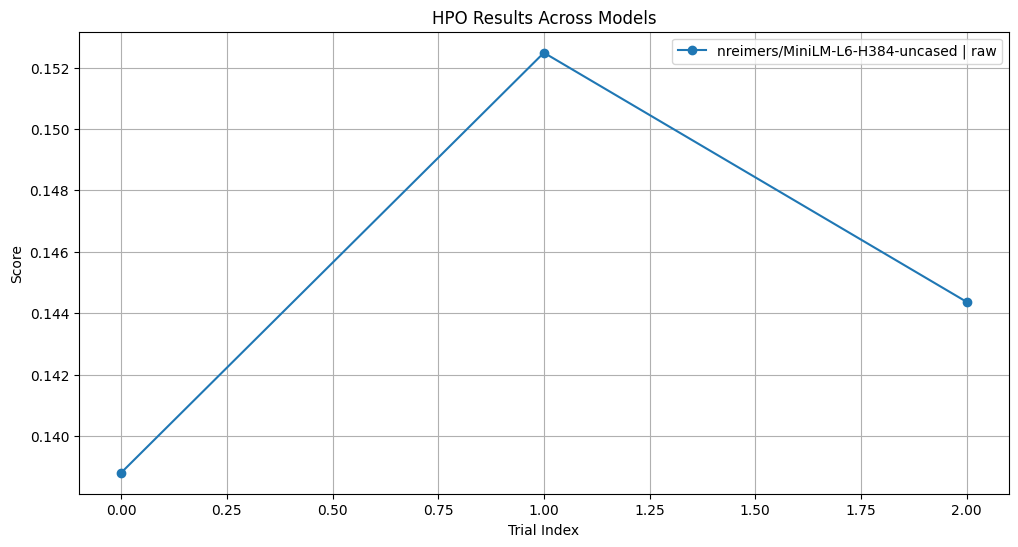


📘 EXPERIMENT SUMMARY TABLE:


,Model,Mode,Best HPO Trial,Best HPO Score,Trained?,Trained Path,Quantized?,Quantized Score,Quantized Path
0,nreimers/MiniLM-L6-H384-uncased,raw,1,0.152482,False,None,False,None,None


📁 Saved summary table to: /content/drive/MyDrive/emotion_project/mini/final_models/plots/experiment_summary.csv


In [30]:
# ============================================================
# UNIVERSAL EXPERIMENT DASHBOARD
#   ✔ Summary table (Pandas dataframe)
#   ✔ Saving all plots to Drive
#   ✔ Robusztus metric-kezelés (eval_ prefix + fallback)
# ============================================================

#if GENERATE_FINAL_REPORT:
if True:

  import json
  import matplotlib.pyplot as plt
  import pandas as pd
  from glob import glob

  PLOTS_DIR = os.path.join(FINAL_DIR, "plots")
  os.makedirs(PLOTS_DIR, exist_ok=True)

  def savefig(name):
      """Helper to save current plot to Drive."""
      path = os.path.join(PLOTS_DIR, name)
      plt.savefig(path, bbox_inches="tight", dpi=200)
      print(f"📁 Saved plot: {path}")


  # ------------------------------------------------------------
  # Helpers
  # ------------------------------------------------------------
  def try_load_json(path):
      if not os.path.exists(path):
          return None
      with open(path, "r") as f:
          return json.load(f)

  def get_metric(metrics_dict, metric_name):
      """
      Robusztus metrika-olvasó:
      - először próbálja a 'metric_name' kulcsot
      - ha nincs, akkor 'eval_metric_name'
      """
      if not metrics_dict:
          return None
      if metric_name in metrics_dict:
          return metrics_dict[metric_name]
      eval_key = f"eval_{metric_name}"
      if eval_key in metrics_dict:
          return metrics_dict[eval_key]
      return None

  def find_hpo_results():
      results = {}
      for model_cfg in BASE_MODELS:
          name = model_cfg["name"]
          key = name.replace("/", "_")
          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              trial_root = os.path.join(TRIALS_DIR, f"{key}_{mode}")
              if not os.path.exists(trial_root):
                  continue
              trial_jsons = sorted(glob(os.path.join(trial_root, "trial_*/metrics.json")))
              trials = [try_load_json(p) for p in trial_jsons if try_load_json(p)]
              if trials:
                  results[(name, mode)] = trials
      return results

  def find_trained_models():
      trained = []
      for model_cfg in BASE_MODELS:
          name = model_cfg["name"]
          key = name.replace("/", "_")
          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              p = os.path.join(FINAL_DIR, f"{key}_{mode}_final_trained")
              if os.path.exists(p):
                  trained.append((name, mode, p))
      return trained

  def find_quantized_models():
      quant = []
      for model_cfg in BASE_MODELS:
          name = model_cfg["name"]
          key = name.replace("/", "_")
          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              p = os.path.join(FINAL_DIR, f"{key}_{mode}_quantized_final")
              if not os.path.exists(p):
                  continue
              summary = try_load_json(os.path.join(p, "quantization_summary.json"))
              quant.append((name, mode, p, summary))
      return quant


  # ============================================================
  # 1) PLOT HPO RESULTS (AND SAVE)
  # ============================================================

  hpo_results = find_hpo_results()

  if hpo_results:
      print(hpo_results)
      print("📊 Plotting HPO results...")

      plt.figure(figsize=(12, 6))

      for (model_name, mode), trials in hpo_results.items():
          metric = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"
          xs = [t.get("trial_index", i) for i, t in enumerate(trials)]
          ys = [
              get_metric(t.get("eval_metrics", {}), metric) or 0.0
              for t in trials
          ]
          plt.plot(xs, ys, marker="o", label=f"{model_name} | {mode}")

      plt.title("HPO Results Across Models")
      plt.xlabel("Trial Index")
      plt.ylabel("Score")
      plt.grid(True)
      plt.legend()
      savefig("hpo_results.png")
      plt.show()
  else:
      print("⚠ No HPO results found.")


  # ============================================================
  # 2) PLOT TRAINING CURVES (AND SAVE)
  # ============================================================

  trained_models = find_trained_models()

  for (model_name, mode, path) in trained_models:
      print(f"\n📈 Plotting training curves for {model_name} | {mode}")

      state_path = os.path.join(path, "trainer_state.json")
      state = try_load_json(state_path)

      if not state:
          print("  ⚠ trainer_state.json missing")
          continue

      logs = state.get("log_history", [])
      train_loss = [l["loss"] for l in logs if "loss" in l]
      eval_loss = [l["eval_loss"] for l in logs if "eval_loss" in l]

      # Training Loss
      if train_loss:
          plt.figure(figsize=(10, 4))
          plt.plot(train_loss)
          plt.title(f"Training Loss — {model_name} ({mode})")
          plt.xlabel("Step")
          plt.ylabel("Loss")
          plt.grid(True)
          name = f"training_loss_{model_name.replace('/', '_')}_{mode}.png"
          savefig(name)
          plt.show()

      # Eval Loss
      if eval_loss:
          plt.figure(figsize=(10, 4))
          plt.plot(eval_loss, marker="o")
          plt.title(f"Eval Loss — {model_name} ({mode})")
          plt.xlabel("Epoch")
          plt.ylabel("Eval Loss")
          plt.grid(True)
          name = f"eval_loss_{model_name.replace('/', '_')}_{mode}.png"
          savefig(name)
          plt.show()


  # ============================================================
  # 3) FULL vs QUANTIZED PERFORMANCE (AND SAVE)
  # ============================================================

  quantized_models = find_quantized_models()

  for (model_name, mode, p, summary) in quantized_models:
      if not summary or "quantized_metrics" not in summary:
          continue

      metric = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"
      q_val = get_metric(summary["quantized_metrics"], metric)

      # Load full model metric
      key = model_name.replace("/", "_")
      full_path = os.path.join(FINAL_DIR, f"{key}_{mode}_final_trained")
      trainer_state = try_load_json(os.path.join(full_path, "trainer_state.json"))

      full_val = None
      if trainer_state:
          eval_logs = [
              l for l in trainer_state.get("log_history", [])
              if f"eval_{metric}" in l
          ]
          if eval_logs:
              full_val = eval_logs[-1][f"eval_{metric}"]

      if full_val is None or q_val is None:
          print(f"⚠ Missing full/quantized metrics for {model_name} ({mode})")
          continue

      plt.figure(figsize=(6, 4))
      plt.bar(["Full", "Quantized"], [full_val, q_val])
      plt.title(f"{metric}: Full vs Quantized — {model_name} ({mode})")
      plt.ylabel(metric)
      plt.grid(axis="y")
      name = f"full_vs_quant_{model_name.replace('/', '_')}_{mode}.png"
      savefig(name)
      plt.show()


  # ============================================================
  # 4) SUMMARY TABLE
  # ============================================================

  rows = []
  for (model_name, mode), hpo_trials in hpo_results.items():
      metric = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"

      # best trial robusztus kiválasztása
      def trial_score(t):
          return get_metric(t.get("eval_metrics", {}), metric) or -1.0

      best_trial = max(hpo_trials, key=trial_score)

      # trained?
      trained_path = os.path.join(
          FINAL_DIR,
          f"{model_name.replace('/', '_')}_{mode}_final_trained"
      )
      is_trained = os.path.exists(trained_path)

      # quantized?
      quant_path = os.path.join(
          FINAL_DIR,
          f"{model_name.replace('/', '_')}_{mode}_quantized_final"
      )
      quant_summary = try_load_json(os.path.join(quant_path, "quantization_summary.json"))

      quant_score = None
      if quant_summary and "quantized_metrics" in quant_summary:
          quant_score = get_metric(quant_summary["quantized_metrics"], metric)

      rows.append({
          "Model": model_name,
          "Mode": mode,
          "Best HPO Trial": best_trial.get("trial_index"),
          "Best HPO Score": trial_score(best_trial),
          "Trained?": is_trained,
          "Trained Path": trained_path if is_trained else None,
          "Quantized?": quant_summary is not None,
          "Quantized Score": quant_score,
          "Quantized Path": quant_path if quant_summary else None,
      })

  df_summary = pd.DataFrame(rows)
  print("\n📘 EXPERIMENT SUMMARY TABLE:")
  display(df_summary)

  # Save summary table
  df_summary.to_csv(os.path.join(PLOTS_DIR, "experiment_summary.csv"), index=False)
  print(f"📁 Saved summary table to: {os.path.join(PLOTS_DIR, 'experiment_summary.csv')}")


In [31]:
# ============================================================
# FINAL REPORT GENERATOR → PDF
# Output:
#   /content/drive/MyDrive/emotion_project/final_report/final_report.pdf
# ============================================================

#if GENERATE_FINAL_REPORT:
if True:
  !pip install -q reportlab

  import os
  import json
  import datetime
  from glob import glob

  import pandas as pd
  from reportlab.lib.pagesizes import A4
  from reportlab.platypus import (
      SimpleDocTemplate,
      Paragraph,
      Spacer,
      Table,
      TableStyle,
      PageBreak,
  )
  from reportlab.lib.styles import getSampleStyleSheet
  from reportlab.lib import colors

  # -----------------------------
  # Paths
  # -----------------------------
  REPORT_DIR = os.path.join(PROJECT_ROOT, "final_report")
  os.makedirs(REPORT_DIR, exist_ok=True)

  REPORT_PDF = os.path.join(REPORT_DIR, "final_report.pdf")

  print("Report directory:", REPORT_DIR)
  print("Report PDF will be saved to:", REPORT_PDF)


  # -----------------------------
  # Helper functions (reuse logic from dashboard, de lokálisan)
  # -----------------------------
  def try_load_json(path):
      if not os.path.exists(path):
          return None
      with open(path, "r") as f:
          return json.load(f)

  def get_metric(metrics_dict, metric_name):
      """
      Robusztus metrika-olvasó:
      - először próbálja a 'metric_name' kulcsot
      - ha nincs, akkor 'eval_metric_name'
      """
      if not metrics_dict:
          return None
      if metric_name in metrics_dict:
          return metrics_dict[metric_name]
      eval_key = f"eval_{metric_name}"
      if eval_key in metrics_dict:
          return metrics_dict[eval_key]
      return None


  def find_hpo_results():
      results = {}
      for model_cfg in BASE_MODELS:
          name = model_cfg["name"]
          key = name.replace("/", "_")
          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              trial_root = os.path.join(TRIALS_DIR, f"{key}_{mode}")
              if not os.path.exists(trial_root):
                  continue
              trial_jsons = sorted(glob(os.path.join(trial_root, "trial_*/metrics.json")))
              trials = [try_load_json(p) for p in trial_jsons if try_load_json(p)]
              if trials:
                  results[(name, mode)] = trials
      return results


  def find_trained_models():
      trained = []
      for model_cfg in BASE_MODELS:
          name = model_cfg["name"]
          key = name.replace("/", "_")
          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              p = os.path.join(FINAL_DIR, f"{key}_{mode}_final_trained")
              if os.path.exists(p):
                  trained.append((name, mode, p))
      return trained


  def find_quantized_models():
      quant = []
      for model_cfg in BASE_MODELS:
          name = model_cfg["name"]
          key = name.replace("/", "_")
          for mode in [RAW_CONFIG_NAME, SIMPLIFIED_CONFIG_NAME]:
              p = os.path.join(FINAL_DIR, f"{key}_{mode}_quantized_final")
              if not os.path.exists(p):
                  continue
              summary = try_load_json(os.path.join(p, "quantization_summary.json"))
              quant.append((name, mode, p, summary))
      return quant


  # -----------------------------
  # Collect experiment artifacts
  # -----------------------------
  hpo_results = find_hpo_results()
  trained_models = find_trained_models()
  quantized_models = find_quantized_models()

  print(f"HPO result sets: {len(hpo_results)}")
  print(f"Trained models: {len(trained_models)}")
  print(f"Quantized models: {len(quantized_models)}")

  # Build a summary dataframe similar to the dashboard
  summary_rows = []
  for (model_name, mode), hpo_trials in hpo_results.items():
      metric = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"

      def trial_score(t):
          return get_metric(t.get("eval_metrics", {}), metric) or -1.0

      best_trial = max(
          hpo_trials,
          key=trial_score,
      )

      key = model_name.replace("/", "_")
      trained_path = os.path.join(FINAL_DIR, f"{key}_{mode}_final_trained")
      is_trained = os.path.exists(trained_path)

      quant_path = os.path.join(FINAL_DIR, f"{key}_{mode}_quantized_final")
      quant_summary = try_load_json(os.path.join(quant_path, "quantization_summary.json"))

      quant_score = None
      if quant_summary and "quantized_metrics" in quant_summary:
          quant_score = get_metric(quant_summary["quantized_metrics"], metric)

      summary_rows.append(
          {
              "Model": model_name,
              "Mode": mode,
              "Best HPO Trial": best_trial.get("trial_index"),
              "Best HPO Score": trial_score(best_trial),
              "Trained?": is_trained,
              "Trained Path": trained_path if is_trained else None,
              "Quantized?": quant_summary is not None,
              "Quantized Score": quant_score,
              "Quantized Path": quant_path if quant_summary else None,
          }
      )

  df_summary = pd.DataFrame(summary_rows) if summary_rows else pd.DataFrame()
  summary_csv_path = os.path.join(REPORT_DIR, "experiment_summary_for_report.csv")
  df_summary.to_csv(summary_csv_path, index=False)
  print("Saved summary CSV for report:", summary_csv_path)


  # -----------------------------
  # Build PDF document
  # -----------------------------
  styles = getSampleStyleSheet()
  style_title = styles["Title"]
  style_h1 = styles["Heading1"]
  style_h2 = styles["Heading2"]
  style_body = styles["BodyText"]

  story = []

  # ========== TITLE PAGE ==========
  title = "Lightweight Emotion Detection from Text — Final Report"
  today = datetime.date.today().strftime("%Y-%m-%d")

  story.append(Paragraph(title, style_title))
  story.append(Spacer(1, 24))
  story.append(Paragraph("Team: (to be filled in)", style_body))
  story.append(Paragraph(f"Date: {today}", style_body))
  story.append(Spacer(1, 40))

  model_names_str = ", ".join(sorted({cfg["name"] for cfg in BASE_MODELS}))
  story.append(Paragraph(f"Models considered: {model_names_str}", style_body))
  story.append(PageBreak())


  # ========== 1. OVERVIEW ==========
  story.append(Paragraph("1. Overview", style_h1))
  overview_text = """
  This report summarizes our experiments on lightweight emotion detection from text,
  using the GoEmotions dataset in two configurations: RAW (multi-label) and SIMPLIFIED
  (single-label). The main goals were:

  • to compare several compact transformer models on this task,
  • to incorporate a Plutchik-distance–aware evaluation instead of plain F1,
  • to explore a simple manual hyperparameter search (HPO) grid,
  • and to study the impact of INT8 quantization on model performance and size.
  """
  for line in overview_text.strip().split("\n"):
      story.append(Paragraph(line.strip(), style_body))
  story.append(Spacer(1, 12))


  # ========== 2. DATA & LABELLING ==========
  story.append(Paragraph("2. Data and Labelling Schemes", style_h1))

  raw_text = """
  RAW configuration:
  The RAW GoEmotions configuration is treated as a multi-label problem with 28 active emotion
  labels plus 'neutral'. Each text can have multiple emotions simultaneously, represented as
  a 28-dimensional multi-hot vector. We use a BCEWithLogitsLoss with per-label pos_weight
  to account for class imbalance.
  """

  simp_text = """
  SIMPLIFIED configuration:
  The SIMPLIFIED configuration provided by the dataset authors maps each example to a single
  dominant emotion label using a fixed priority rule over the annotations. This turns the problem
  into a single-label classification task with 20 emotion classes. For this setting we use a
  standard cross-entropy loss, optionally with class weights.
  """

  for t in (raw_text, simp_text):
      for line in t.strip().split("\n"):
          story.append(Paragraph(line.strip(), style_body))
      story.append(Spacer(1, 6))

  plutchik_text = """
  Plutchik-aware evaluation:
  Following your suggestion, we incorporate Plutchik's wheel-of-emotions as a simple distance
  model between emotions. For the RAW setting, we define a Plutchik-aware F1 score that gives
  partial credit when predicted emotions share the same Plutchik primary category as the true
  labels. For the SIMPLIFIED setting, we use a soft accuracy that awards 1.0 for exact matches,
  0.5 for same primary category, and 0.25 when one of the emotions is 'neutral'.
  """

  for line in plutchik_text.strip().split("\n"):
      story.append(Paragraph(line.strip(), style_body))
  story.append(Spacer(1, 12))


  # ========== 3. MODELS & TRAINING ==========
  story.append(Paragraph("3. Models and Training Setup", style_h1))

  models_text = """
  Models:
  We focus on three lightweight transformer-based encoders:

  • nreimers/MiniLM-L6-H384-uncased
  • google/electra-small-discriminator
  • roberta-base

  All models are fine-tuned for emotion detection using our custom WeightedTrainer. For the
  RAW (multi-label) setting we use BCEWithLogitsLoss with pos_weight; for the SIMPLIFIED
  setting, cross-entropy with optional class weights. A global seed is used for reproducibility.
  """

  for line in models_text.strip().split("\n"):
      story.append(Paragraph(line.strip(), style_body))
  story.append(Spacer(1, 6))

  hpo_text = """
  Manual HPO:
  Instead of a black-box hyperparameter search, we use a small manually designed grid of
  three configurations (learning rate, warmup ratio, weight decay, scheduler type, batch size,
  and max sequence length). For each model we only run HPO on the RAW configuration.
  For the SIMPLIFIED setting we simply reuse the best RAW hyperparameters, to save
  computation and to keep the comparison consistent.
  """

  for line in hpo_text.strip().split("\n"):
      story.append(Paragraph(line.strip(), style_body))
  story.append(Spacer(1, 12))


  # ========== 4. HPO RESULTS ==========
  story.append(Paragraph("4. Hyperparameter Optimization Results", style_h1))

  if df_summary.empty:
      story.append(Paragraph("No HPO results found yet in TRIALS_DIR.", style_body))
  else:
      story.append(
          Paragraph(
              "Table 1: Best HPO result per model and configuration "
              "(Plutchik-aware score).",
              style_h2,
          )
      )
      story.append(Spacer(1, 6))

      table_data = [
          [
              "Model",
              "Mode",
              "Best HPO Trial",
              "Best HPO Score",
              "Trained?",
              "Quantized?",
          ]
      ]

      for _, row in df_summary.iterrows():
          best_score = row["Best HPO Score"]
          table_data.append(
              [
                  str(row["Model"]),
                  str(row["Mode"]),
                  int(row["Best HPO Trial"]) if pd.notna(row["Best HPO Trial"]) else "N/A",
                  f"{best_score:.4f}" if pd.notna(best_score) else "N/A",
                  "Yes" if row["Trained?"] else "No",
                  "Yes" if row["Quantized?"] else "No",
              ]
          )

      table = Table(table_data, hAlign="LEFT")
      table.setStyle(
          TableStyle(
              [
                  ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
                  ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
                  ("ALIGN", (0, 0), (-1, -1), "CENTER"),
                  ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
              ]
          )
      )
      story.append(table)

  story.append(Spacer(1, 12))


  # ========== 5. FINAL TRAINING & PERFORMANCE ==========
  story.append(Paragraph("5. Final Training and Model Performance", style_h1))

  if not trained_models:
      story.append(
          Paragraph(
              "Final training has not been run yet (no *_final_trained directories found).",
              style_body,
          )
      )
  else:
      text = """
  For each model with available HPO results we perform a final training run using the best
  RAW hyperparameters. For the SIMPLIFIED setting we reuse the same hyperparameters.
  Performance is evaluated both with the standard metric (micro F1 / accuracy) and our
  Plutchik-aware metric.
  """
      for line in text.strip().split("\n"):
          story.append(Paragraph(line.strip(), style_body))
      story.append(Spacer(1, 6))

      story.append(
          Paragraph(
              "Training summaries (per model/mode) are stored next to the final trained "
              "models and can be inspected for detailed metrics and learning curves.",
              style_body,
          )
      )

  story.append(Spacer(1, 12))


  # ========== 6. QUANTIZATION ==========
  story.append(Paragraph("6. Quantization (FP32 vs INT8)", style_h1))

  if not quantized_models:
      story.append(
          Paragraph(
              "No quantized models found yet (no *_quantized_final directories with "
              "quantization_summary.json).",
              style_body,
          )
      )
  else:
      text = """
  We apply PyTorch dynamic quantization to the best final models, targeting Linear layers
  and converting them to INT8 where possible. When quantization fails, we fall back to
  exporting the FP32 weights. For each quantized model we re-evaluate the Plutchik-aware
  metric to measure the accuracy drop.
  """
      for line in text.strip().split("\n"):
          story.append(Paragraph(line.strip(), style_body))
      story.append(Spacer(1, 6))

      story.append(Paragraph("Table 2: Quantization summary.", style_h2))
      story.append(Spacer(1, 6))

      q_table_data = [
          ["Model", "Mode", "Quantization OK?", "Quantized Score (Plutchik)"]
      ]

      for (model_name, mode, p, summary) in quantized_models:
          if not summary or "quantized_metrics" not in summary:
              continue
          metric = "plutchik_f1" if mode == RAW_CONFIG_NAME else "plutchik_soft"
          q_val = get_metric(summary["quantized_metrics"], metric)
          q_table_data.append(
              [
                  model_name,
                  mode,
                  "Yes" if summary.get("quantized_success") else "No",
                  f"{q_val:.4f}" if q_val is not None else "N/A",
              ]
          )

      if len(q_table_data) > 1:
          q_table = Table(q_table_data, hAlign="LEFT")
          q_table.setStyle(
              TableStyle(
                  [
                      ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
                      ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
                      ("ALIGN", (0, 0), (-1, -1), "CENTER"),
                      ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
                  ]
              )
          )
          story.append(q_table)
      else:
          story.append(Paragraph("No detailed quantization summaries found.", style_body))

  story.append(Spacer(1, 12))


  # ========== 7. RAW vs SIMPLIFIED & MODEL DIFFERENCES ==========
  story.append(
      Paragraph("7. RAW vs SIMPLIFIED, and Model Differences", style_h1)
  )

  text_reason = """
  Difference between best models for RAW and SIMPLIFIED:
  In the RAW multi-label setting, the models are optimized to detect possibly several emotions
  per example. This tends to favour architectures that handle label co-occurrence patterns
  well and make use of the pos_weight vector. In the SIMPLIFIED single-label setup, the task
  is closer to standard multi-class classification, and the priority-based label selection
  can emphasise different parts of the label space. As a result, the relative ranking of
  models can differ between RAW and SIMPLIFIED.
  """

  for line in text_reason.strip().split("\n"):
      story.append(Paragraph(line.strip(), style_body))
  story.append(Spacer(1, 12))


  # ========== 8. PERFORMANCE INTERPRETATION ==========
  story.append(Paragraph("8. Performance Interpretation", style_h1))

  perf_text = """
  The raw F1 scores in earlier versions of the report were in the 0.47 range, which is modest
  for a classification task. However, this is partly due to the multi-label nature of emotions:
  expecting exact label-set matches is very strict. With the Plutchik-aware metrics we can
  distinguish between 'close' and 'far' mistakes (e.g., confusing joy with optimism vs joy
  with disgust), which gives a more informative picture of model behaviour.

  We also plan to inspect the main contributors to false positives and false negatives per label
  (e.g., which emotions are systematically over-predicted or under-predicted) and to include
  a small set of representative error examples in the final written report.
  """

  for line in perf_text.strip().split("\n"):
      story.append(Paragraph(line.strip(), style_body))

  story.append(Spacer(1, 12))


  # ========== 9. COMPUTATIONAL CONSIDERATIONS ==========
  story.append(Paragraph("9. Computational Considerations", style_h1))

  comp_text = """
  All experiments are run on Google Colab GPUs, which limits how many models and configurations
  we can train in one notebook run. For this reason, we:

  • run manual HPO only on the RAW configuration,
  • reuse the best RAW hyperparameters for the SIMPLIFIED setting,
  • train and quantize models one-by-one by toggling flags at the top of the notebook.

  We kept a global random seed and a fixed train/validation split to make results as
  reproducible as possible given these constraints.
  """

  for line in comp_text.strip().split("\n"):
      story.append(Paragraph(line.strip(), style_body))

  story.append(PageBreak())


  # ========== 10. APPENDIX: SUMMARY TABLE ==========
  story.append(Paragraph("10. Appendix: Experiment Summary Table", style_h1))

  if df_summary.empty:
      story.append(
          Paragraph(
              "No summary rows available yet. Please run HPO and training first.",
              style_body,
          )
      )
  else:
      story.append(
          Paragraph(
              f"Full summary also saved as CSV at: {summary_csv_path}", style_body
          )
      )
      story.append(Spacer(1, 6))

      # Render a small version of the summary table in the PDF (first N rows)
      max_rows = 15
      pdf_rows = min(len(df_summary), max_rows)
      story.append(
          Paragraph(
              f"Table 3: Overview of best HPO, training, and quantization status "
              f"for the first {pdf_rows} configurations.",
              style_h2,
          )
      )
      story.append(Spacer(1, 6))

      header = list(df_summary.columns)
      data = [header]
      for i in range(pdf_rows):
          row = df_summary.iloc[i]
          data.append([str(row[h]) for h in header])

      sum_table = Table(data, hAlign="LEFT")
      sum_table.setStyle(
          TableStyle(
              [
                  ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
                  ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
                  ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
                  ("ALIGN", (0, 0), (-1, -1), "LEFT"),
              ]
          )
      )
      story.append(sum_table)

  # -----------------------------
  # Build and save PDF
  # -----------------------------
  print("\nBuilding PDF report...")
  doc = SimpleDocTemplate(REPORT_PDF, pagesize=A4)
  doc.build(story)
  print("✅ Report written to:", REPORT_PDF)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.5 MB/s eta 0:00:00
Report directory: /content/drive/MyDrive/emotion_project/final_report
Report PDF will be saved to: /content/drive/MyDrive/emotion_project/final_report/final_report.pdf
HPO result sets: 1
Trained models: 0
Quantized models: 0
Saved summary CSV for report: /content/drive/MyDrive/emotion_project/final_report/experiment_summary_for_report.csv

Building PDF report...
✅ Report written to: /content/drive/MyDrive/emotion_project/final_report/final_report.pdf
